In [1]:
import numpy as np
import pandas as pd

In [2]:
# Загружаем все необходимые датасеты
train = pd.read_csv('/home/exeb1t/Desktop/Kaggle/StoreSales/train.csv')
test = pd.read_csv('/home/exeb1t/Desktop/Kaggle/StoreSales/test.csv')
oil = pd.read_csv('/home/exeb1t/Desktop/Kaggle/StoreSales/oil.csv')
holidays_events = pd.read_csv('/home/exeb1t/Desktop/Kaggle/StoreSales/holidays_events.csv')
stores = pd.read_csv('/home/exeb1t/Desktop/Kaggle/StoreSales/stores.csv')
transactions = pd.read_csv('/home/exeb1t/Desktop/Kaggle/StoreSales/transactions.csv')

In [3]:
# Для начала преобразуем
train_test = pd.concat([train, test], sort=False, axis=0, ignore_index=True)

In [4]:
train_test = train_test.drop(['id'], axis=1)

In [5]:
train_test

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1
3029396,2017-08-31,9,PREPARED FOODS,NaN,0
3029397,2017-08-31,9,PRODUCE,NaN,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9


In [6]:
# Добавляем текущий день, месяц, год, день зарплаты
from datetime import date, datetime
import calendar


train_test['date'] = train_test['date'].map(lambda x: date.fromisoformat(x))
train_test['weekday'] = train_test['date'].map(lambda x: x.weekday())
train_test['year'] = train_test['date'].map(lambda x: x.year)
train_test['month'] = train_test['date'].map(lambda x: x.month)
train_test['day'] = train_test['date'].map(lambda x: x.day)
train_test['eomd'] = train_test['date'].map(lambda x: calendar.monthrange(x.year, x.month)[1])
train_test['payday'] = ((train_test['day'] == train_test['eomd']) | (train_test['day'] == 15)).astype(int)

train_test = train_test.drop(['eomd'], axis=1)

In [7]:
train_test

,date,store_nbr,family,sales,onpromotion,weekday,year,month,day,payday
0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,2013,1,1,0
1,2013-01-01,1,BABY CARE,0.0,0,1,2013,1,1,0
2,2013-01-01,1,BEAUTY,0.0,0,1,2013,1,1,0
3,2013-01-01,1,BEVERAGES,0.0,0,1,2013,1,1,0
4,2013-01-01,1,BOOKS,0.0,0,1,2013,1,1,0
...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,3,2017,8,31,1
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,3,2017,8,31,1
3029397,2017-08-31,9,PRODUCE,NaN,1,3,2017,8,31,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,3,2017,8,31,1


In [8]:
# Чтобы максимально точно заполнить пропуски в датасете oil мы посчитаем среднее значение
# цены на каждый месяц и заполним им
oil['year_month'] = oil['date'].map(lambda x: int(x.replace('-', '')[:6]))
oil['year_month_avg'] = oil.groupby('year_month')['dcoilwtico'].transform('mean')
oil['tmp'] = oil['dcoilwtico'].map(np.isnan)
oil['year_month_avg'] = oil['tmp'] * oil['year_month_avg']
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(0)
oil['dcoilwtico'] = oil['dcoilwtico'] + oil['year_month_avg']
oil = oil.drop(['year_month', 'year_month_avg', 'tmp'], axis=1)
oil['date'] = oil['date'].map(lambda x: date.fromisoformat(x))


In [9]:
holidays_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [10]:
holidays_events['date'] = holidays_events['date'].map(lambda x: date.fromisoformat(x))
holiday = holidays_events[(holidays_events['transferred']==False)&(holidays_events['type']!='Work Day')]
event = holiday[holiday['type']=='Event']
earthquake = event[event['description'].str.startswith('Terremoto Manabi')]
event = event[event['description'].str.startswith('Terremoto Manabi')==False]

In [11]:
event = event[['date', 'description']]
event.rename({'description':'event_name'}, axis=1, inplace=True)

In [12]:
earthquake = earthquake[['date', 'description']]
earthquake.rename({'description':'earthquake'}, axis=1, inplace=True)

In [13]:
h_local = holiday[holiday['locale']=='Local']
h_local = h_local[['date', 'locale_name', 'description']]
h_local = h_local.rename({'locale_name':'city', 'description':'locale_holiday_name'}, axis=1)

In [14]:
h_regional = holiday[holiday['locale']=='Regional']
h_regional = h_regional[['date', 'locale_name', 'description']]
h_regional = h_regional.rename({'locale_name':'state', 'description':'regional_holiday_name'}, axis=1)

In [15]:
h_national = holiday[holiday['locale']=='National']
h_national = h_national[['date','description']]
h_national = h_national.rename({'description':'national_holiday_name'}, axis=1)

In [16]:
def merge_tables(df):
    df = df.merge(oil, on='date', how='left')
    df = df.merge(stores, on='store_nbr', how='left')
    df = df.merge(event, on='date', how='left').fillna('0')
    df = df.merge(earthquake, on='date', how='left').fillna('0')
    df = df.merge(h_local, on=['date', 'city'], how='left').fillna('0')
    df = df.merge(h_regional, on=['date', 'state'], how='left').fillna('0')
    df = df.merge(h_national, on='date', how='left').fillna('0')
    df = df.merge(transactions, on=['date', 'store_nbr'], how='left').fillna(0)

    return df

train_test = merge_tables(train_test)


In [17]:
train_test['dcoilwtico'] = train_test['dcoilwtico'].astype(float)

In [18]:
from sklearn.preprocessing import LabelEncoder

cat_features = ['family', 'store_nbr', 'city', 'state', 'type', 'cluster',
                'event_name', 'earthquake', 'locale_holiday_name', 'regional_holiday_name', 'national_holiday_name']
for col in cat_features:
    le = LabelEncoder()
    train_test[col] = le.fit_transform(train_test[col])

In [19]:
train_test

,date,store_nbr,family,sales,onpromotion,weekday,year,month,day,payday,...,city,state,type,cluster,event_name,earthquake,locale_holiday_name,regional_holiday_name,national_holiday_name,transactions
0,2013-01-01,0,0,0.0,0,1,2013,1,1,0,...,18,12,3,12,0,0,0,0,26,0.0
1,2013-01-01,0,1,0.0,0,1,2013,1,1,0,...,18,12,3,12,0,0,0,0,26,0.0
2,2013-01-01,0,2,0.0,0,1,2013,1,1,0,...,18,12,3,12,0,0,0,0,26,0.0
3,2013-01-01,0,3,0.0,0,1,2013,1,1,0,...,18,12,3,12,0,0,0,0,26,0.0
4,2013-01-01,0,4,0.0,0,1,2013,1,1,0,...,18,12,3,12,0,0,0,0,26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3036787,2017-08-31,8,28,0,1,3,2017,8,31,1,...,18,12,1,5,0,0,0,0,0,0.0
3036788,2017-08-31,8,29,0,0,3,2017,8,31,1,...,18,12,1,5,0,0,0,0,0,0.0
3036789,2017-08-31,8,30,0,1,3,2017,8,31,1,...,18,12,1,5,0,0,0,0,0,0.0
3036790,2017-08-31,8,31,0,9,3,2017,8,31,1,...,18,12,1,5,0,0,0,0,0,0.0


In [20]:
df_train = train_test[:3008280]
df_test = train_test[3008280:]
df_test.shape, df_train.shape

((28512, 21), (3008280, 21))

In [21]:
df_test = df_test.drop('sales', axis=1)
df_test.shape

(28512, 20)

In [99]:
def preprocess_dataset(df, train_date:list, valid_date: list):
    df['is_train'] = df['date'].map(lambda x: x in train_date)
    df['is_valid'] = df['date'].map(lambda x: x in valid_date)
    return df
train_date = df_train['date'].unique()[-227:-31].tolist()
valid_date = df_train['date'].unique()[-31:].tolist()
df_train = preprocess_dataset(df_train, train_date, valid_date)

/tmp/ipykernel_2170/3269706171.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_train'] = df['date'].map(lambda x: x in train_date)
/tmp/ipykernel_2170/3269706171.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_valid'] = df['date'].map(lambda x: x in valid_date)


In [100]:
print(f'train date from {min(train_date)} to {max(train_date)}')
print(f'valid date from {min(valid_date)} to {max(valid_date)}')

train date from 2017-01-01 to 2017-07-15
valid date from 2017-07-16 to 2017-08-15


In [101]:
y_train = df_train['sales']
y_train = pd.Series(data=np.log1p(y_train.tolist()), name='sales')
X_train = df_train.drop(['date', 'sales', 'year'], axis=1)
X_test = df_test.drop(['date', 'year'], axis=1)

In [102]:
nan = pd.DataFrame(X_train.isna().sum(), columns=['Nan_sum'])
nan = nan[nan['Nan_sum'] > 0]
nan

,Nan_sum


In [103]:
nan = pd.DataFrame(X_test.isna().sum(), columns=['Nan_sum'])
nan = nan[nan['Nan_sum'] > 0]
nan

,Nan_sum


In [104]:
xgb_params = {
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'predictor': 'gpu_predictor',
    'verbosity': 2,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.00994891,
    'subsample': 0.996359,
    'colsample_bytree': 0.805677952,
    'reg_alpha': 10.0,
    'reg_lambda': 0.1801543144548864,
    'min_child_weight': 47,
}

In [105]:
import time
from sklearn.metrics import mean_squared_error
import xgboost as xgb
def basic_xgboost(X_train, y, xgb_params, X_test):
    start = time.time()
    # extract train and valid dataset
    trn_idx = X_train[X_train['is_train']==True].index.tolist()
    val_idx = X_train[X_train['is_valid']==True].index.tolist()

    X_tr = X_train.loc[trn_idx, :].drop(['is_train', 'is_valid'], axis=1)
    X_val = X_train.loc[val_idx, :].drop(['is_train', 'is_valid'], axis=1)
    y_tr = y[trn_idx]
    y_val = y[val_idx]

    xgb_train = xgb.DMatrix(X_tr, label=y_tr)
    xgb_valid = xgb.DMatrix(X_val, label=y_val)
    evallist = [(xgb_train, 'train'), (xgb_valid, 'eval')]
    evals_result = dict()

    model = xgb.train(params=xgb_params, dtrain=xgb_train, evals=evallist, evals_result=evals_result,
                      verbose_eval=5000, num_boost_round=100000, early_stopping_rounds=100)



    xgb_oof = np.zeros(y_val.shape[0])
    xgb_oof = model.predict(xgb_valid, iteration_range=(0, model.best_iteration))

    xgb_test = xgb.DMatrix(X_test)
    xgb_pred = pd.Series(model.predict(xgb_test, iteration_range=(0, model.best_iteration)),
                         name='xgb_pred')

    elapsed = time.time() - start
    error_value = mean_squared_error(y_val, xgb_oof, squared=False)
    print(f"xgb rmse: {error_value:.6f}, elapsed time: {elapsed:.2f}sec\n")

    return xgb_oof, model, evals_result, xgb_pred, y_val, X_val

In [107]:
%%time
oof, model, eval_result, pred, y_val, X_val = basic_xgboost(X_train, y_train, xgb_params, X_test)

[0]	train-rmse:3.95624	eval-rmse:3.97925
[5000]	train-rmse:0.43576	eval-rmse:0.45832
[10000]	train-rmse:0.40491	eval-rmse:0.43824
[15000]	train-rmse:0.38943	eval-rmse:0.43086
[20000]	train-rmse:0.37986	eval-rmse:0.42703
[25000]	train-rmse:0.37350	eval-rmse:0.42489
[25198]	train-rmse:0.37329	eval-rmse:0.42485
xgb rmse: 0.424847, elapsed time: 103.03sec

CPU times: user 1min 44s, sys: 761 ms, total: 1min 44s
Wall time: 1min 43s


In [108]:
df_error = X_val[['store_nbr', 'family']].copy()
df_error.reset_index(drop=True, inplace=True)
df_error['oof'] = pd.Series(oof)
df_error['y_valid'] = y_val.reset_index(drop=True).copy()

<AxesSubplot:>

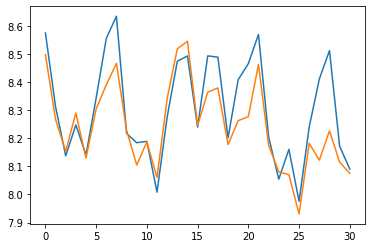

In [110]:
# good
import seaborn as sns
y_oof = df_error[(df_error['store_nbr']==1)&(df_error['family']==12)]['oof'].tolist()
y_val = df_error[(df_error['store_nbr']==1)&(df_error['family']==12)]['y_valid'].tolist()
sns.lineplot(x=range(len(y_oof)), y=y_oof)
sns.lineplot(x=range(len(y_oof)), y=y_val)

<AxesSubplot:>

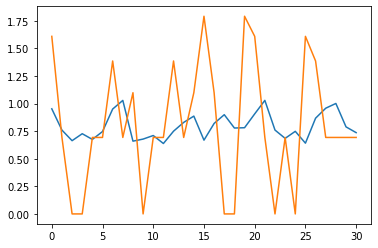

In [111]:
# need to improve
y_oof = df_error[(df_error['store_nbr']==1)&(df_error['family']==14)]['oof'].tolist()
y_val = df_error[(df_error['store_nbr']==1)&(df_error['family']==14)]['y_valid'].tolist()
sns.lineplot(x=range(len(y_oof)), y=y_oof)
sns.lineplot(x=range(len(y_oof)), y=y_val)

In [132]:
pred = np.expm1(pred)

In [133]:
sub = pd.DataFrame(data={'id':test.id,'sales':pred})
sub.to_csv('/home/exeb1t/Desktop/sub_sale.csv', index=False)